# Determining optimal hyperparamter configuration for regional fire frequencies 

Authors: Jatan Buch (v1, 220111) || (v2, 220118)

## 1 - Loading packages and data products

In [1]:
import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [2]:
data_dir= "../data/"
pred_input_path= "12km/"
fire_file= data_dir + "burnarea_12km.nc"

In [3]:
fire_L3_freq_df= pd.read_hdf(data_dir + 'clim_L3_fire_freq_data.h5')
L3_weights, _= np.histogram(fire_L3_freq_df['fire_freq'], density= True, bins= [0, 1, 10, 20, 40, 70, 100]) 
sample_L3_weight_arr= pd.cut(fire_L3_freq_df['fire_freq'].to_numpy(), bins= [0, 1, 10, 20, 40, 70, 100], \
                             labels= (L3_weights[0]/L3_weights)/np.sum(L3_weights[0]/L3_weights), include_lowest= True)
fire_L3_freq_df['sample_weight']= sample_L3_weight_arr

fire_L4_freq_df= pd.read_hdf(data_dir + 'clim_L4_fire_freq_data.h5')
L4_weights, _= np.histogram(fire_L4_freq_df['fire_freq'], density= True, bins= [0, 1, 4, 8, 10, 20, 50]) 
sample_L4_weight_arr= pd.cut(fire_L4_freq_df['fire_freq'].to_numpy(), bins= [0, 1, 4, 8, 10, 20, 50], 
                            labels= (L4_weights[0]/L4_weights)/np.sum(L4_weights[0]/L4_weights), include_lowest= True)
fire_L4_freq_df['sample_weight']= sample_L4_weight_arr
#fire_freq_L3_data= np.array(fire_freq_df[fire_freq_df['month'] >= 372].fire_freq, dtype=np.float32)

## 2 - Testing

In [4]:
X_L3_freqs_train, X_L3_freqs_val, y_L3_freqs_train, y_L3_freqs_val, fire_L3_freq_test, X_L3_freqs_test, y_L3_freqs_test, \
        L3_freq_samp_weight_arr= fire_freq_data(fire_L3_freq_df, dropcols= ['index', 'Tmin', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'Elev', 'Camp_dist'])
X_L4_freqs_train, X_L4_freqs_val, y_L4_freqs_train, y_L4_freqs_val, fire_L4_freq_test, X_L4_freqs_test, y_L4_freqs_test, \
        L4_freq_samp_weight_arr= fire_freq_data(fire_L4_freq_df, dropcols= ['index', 'Tmin', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'Elev', 'Camp_dist'])

### 2.1 Fire frequency

In [5]:
%time hp_df= fire_freq_predict(fire_L3_freq_df, fire_L4_freq_df, n_iters= 10, n_epochs= 500, bs= 32)
hp_df.to_hdf('../sav_files/iter_runs_%s/'%date.today().strftime("%y_%m_%d") + 'hyperparams_iter_runs_%s.h5'%date.today().strftime("%y_%m_%d"), key= 'df', mode= 'w')

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Initialized a MDN with 2 layers and 16 neurons
Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


2022-01-24 18:51:57.657435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-24 18:51:57.657600: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


MDN trained for 21 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_1/assets


2022-01-24 18:52:45.682641: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_1/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 124 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_1/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 209 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 10%|████▎                                      | 1/10 [02:20<21:05, 140.63s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 62 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_2/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_2/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 73 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_2/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 242 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.w

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 23 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_3/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 24 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_3/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 72 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_3/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 281 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
 30%|████████████▉                              | 3/10 [08:38<20:19, 174.28s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 41 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_4/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 97 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_4/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 153 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_4/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 233 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.w

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_5/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_5/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 52 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_5/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 225 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.w

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_6/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 55 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_6/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 202 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_6/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 167 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.w

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_7/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 28 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_7/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 358 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_7/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 444 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - 

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 91 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_8/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 40 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_8/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 162 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_8/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 246 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.w

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_9/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 20 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_9/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 162 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_9/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 192 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
 90%|██████████████████████████████████████▋    | 9/10 [38:44<04:20, 260.11s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zipd_iter_10/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 39 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L4_zinb_iter_10/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 115 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zipd_iter_10/assets
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 169 epochs
INFO:tensorflow:Assets written to: ../sav_files/iter_runs_22_01_24/mdn_L3_zinb_iter_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:738: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 16*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: divide by zero encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:739: RuntimeWarning: invalid value encountered in true_divide
  errarr_2= 4*abs(mean_freqs - obs_freqs)/(high_freqs - low_freqs)
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.w

CPU times: user 1h 4min 33s, sys: 5min 23s, total: 1h 9min 56s
Wall time: 42min 44s


In [6]:
n_regions= 18
tot_months= 60
month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([2015, 2016, 2017, 2018, 2019, 2020]) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[11, 12, 13], [14, 16, 18]] #, [16, 17, 18]

freqtestgrps= fire_L4_freq_test.groupby('reg_indx')
reglenarr= np.asarray([len(freqtestgrps.get_group(k)) for k in freqtestgrps.groups.keys()])
cumreglen= np.insert(np.cumsum(reglenarr), 0, 0)

freq_test_size= np.int64(len(y_L3_freqs_test)/n_regions)
freq_arr_1= np.linspace(0, len(y_L3_freqs_test) - freq_test_size, n_regions, dtype= int)
freq_arr_2= freq_arr_1 + freq_test_size

In [26]:
run_id= '22_01_24' 
hp_df= pd.read_hdf('../sav_files/iter_runs_%s'%run_id + '/hyperparams_iter_runs_%s.h5'%run_id)
hp_df= hp_df[hp_df.Pearson_r >= 0.2]
hp_df['tot_metric']= hp_df['Emp_Accuracy']/hp_df['Red_ChiSq_1'] #hp_df= hp_df.drop([2, 14, 30]) --> '22_01_24' 
opt_freq_ind= np.asarray([hp_df.groupby('reg_indx').get_group(i+1).dropna().sort_values(by= ['tot_metric'], ascending= False).iloc[[0]].index for i in range(n_regions)]).flatten()
# hp_df['tot_metric_1']= hp_df['Emp_Accuracy']/hp_df['Red_ChiSq_1']
# hp_df['tot_metric_2']= hp_df['Emp_Accuracy']/hp_df['Red_ChiSq_2'] 
# opt_freq_ind_1= np.asarray([hp_df.groupby('reg_indx').get_group(i).dropna().sort_values(by= ['tot_metric_1'], ascending= False).iloc[[0]].index for i in ind_grid_1.flatten()]).flatten()
# opt_freq_ind_2= np.asarray([hp_df.groupby('reg_indx').get_group(i).dropna().sort_values(by= ['tot_metric_2'], ascending= False).iloc[[0]].index for i in ind_grid_2.flatten()]).flatten()

100%|█████████████████████████████████████████████| 3/3 [01:08<00:00, 22.73s/it]


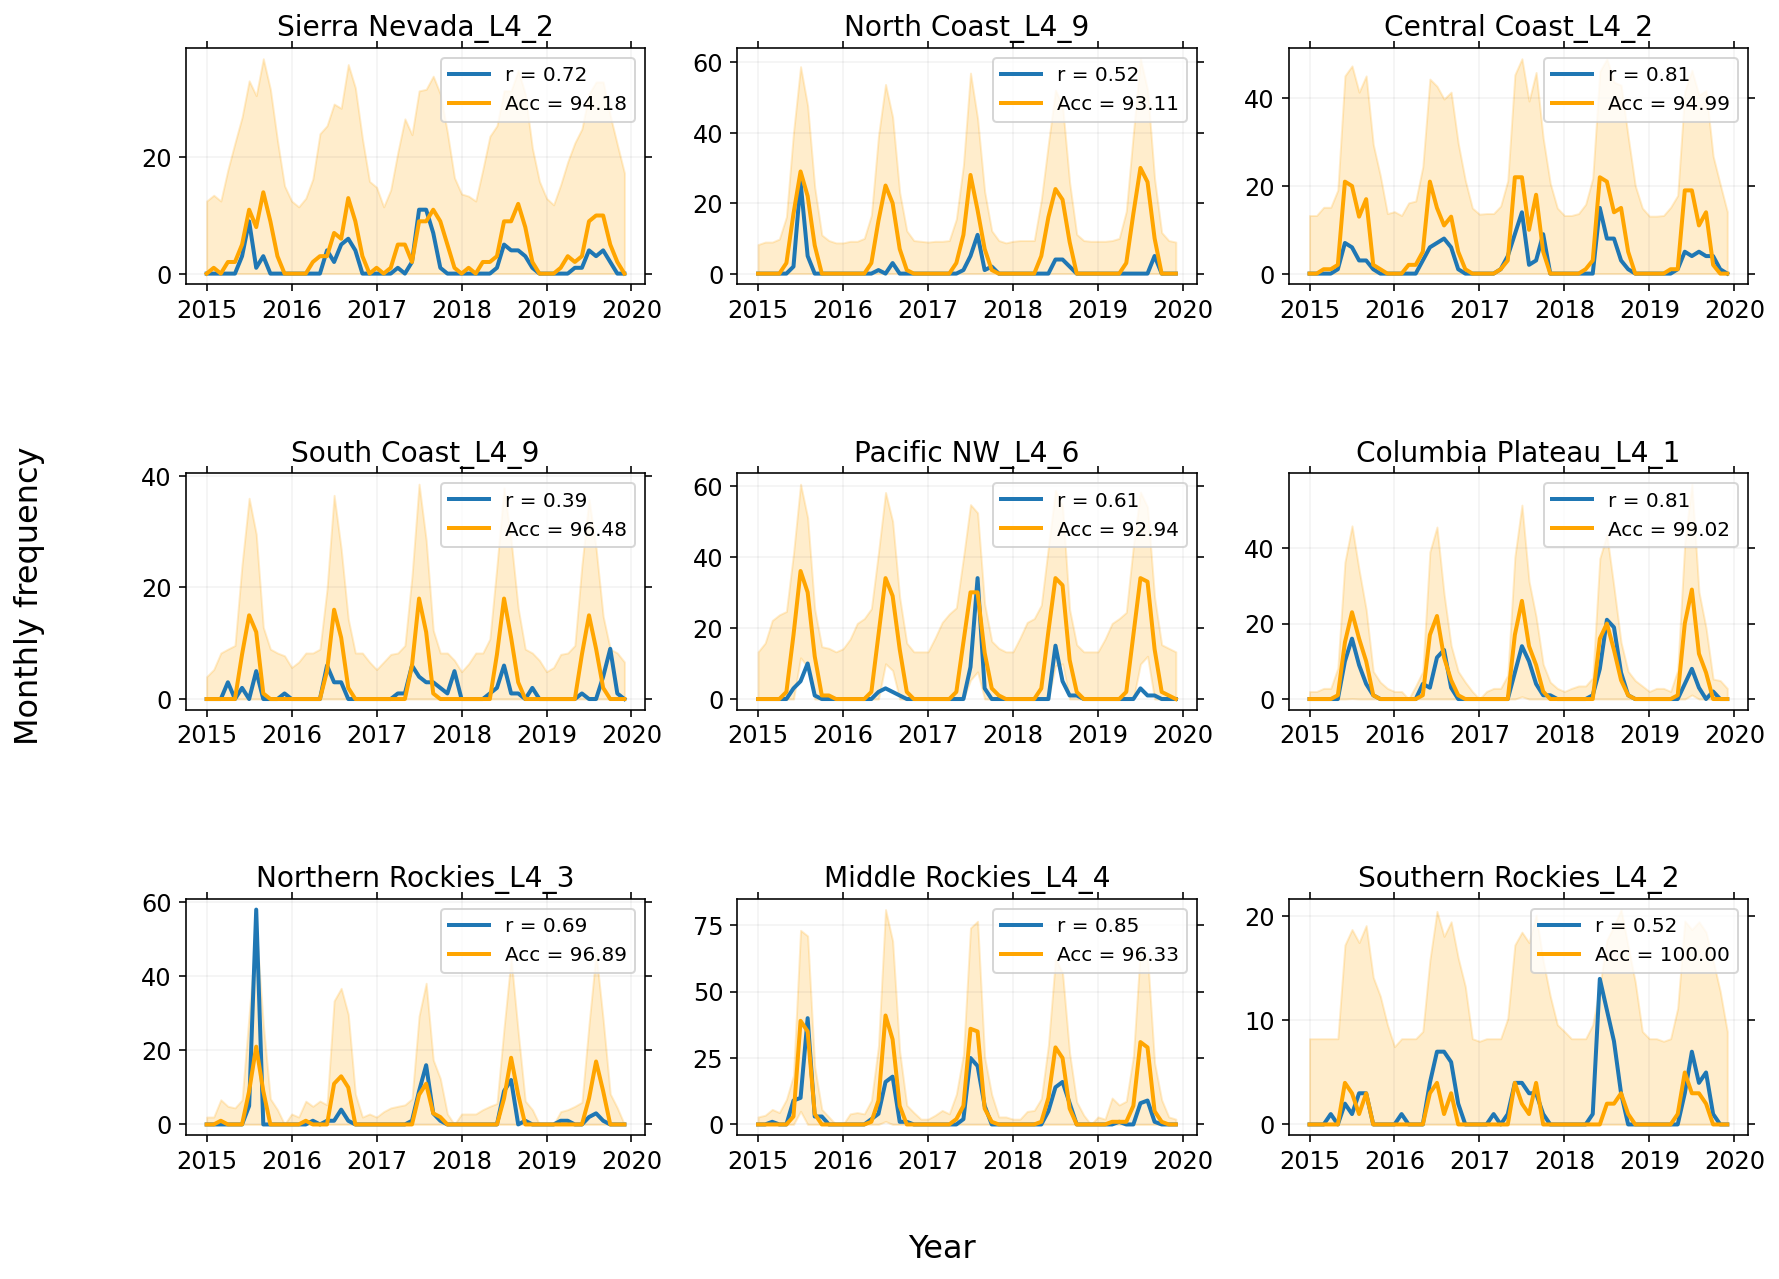

In [32]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)
regmodels= []
freqsarr= []

for i in tqdm(range(3)):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        mod_params= hp_df.loc[opt_freq_ind[regindx - 1]].to_dict()
        
        if mod_params['reg_flag'] == 'L4':
            if mod_params['func_flag'] == 'zipd':
                mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
                regmodels.append(zipd_model(mdn_L4_zipd.predict(x= tf.constant(X_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]]))))
            else:
                mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zinb_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
                regmodels.append(zinb_model(mdn_L4_zinb.predict(x= tf.constant(X_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]]))))
            
            reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
            fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                            for m in range(tot_months)])
            fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0
            
            freqsarr.append(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]])
            ax[i, j].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                for m in range(tot_months)]), lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
                   label= 'Acc = %.2f'%mod_params['Mod_Accuracy']);
            ax[i, j].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
        else:
            if mod_params['func_flag'] == 'zipd':
                mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zipd_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= True)
                regmodels.append(zipd_model(mdn_L3_zipd.predict(x= tf.constant(X_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]]))))
            else:
                mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zinb_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= True)
                regmodels.append(zinb_model(mdn_L3_zinb.predict(x= tf.constant(X_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]]))))

            reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
            freqsarr.append(y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]])
            ax[i, j].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                                label= 'Acc = %.2f'%mod_params['Mod_Accuracy']);
            ax[i, j].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                                     color= 'orange', alpha=0.2);

        ax[i, j].set_title('%s_'%reg_name[regindx] + '%s_'%mod_params['reg_flag'] + '%s'%mod_params['Iteration'], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].legend(loc='upper right', frameon= True);
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_fire_freq_1_emp_acc_rchisq_%s.pdf'%run_id, bbox_inches='tight');

100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.52s/it]


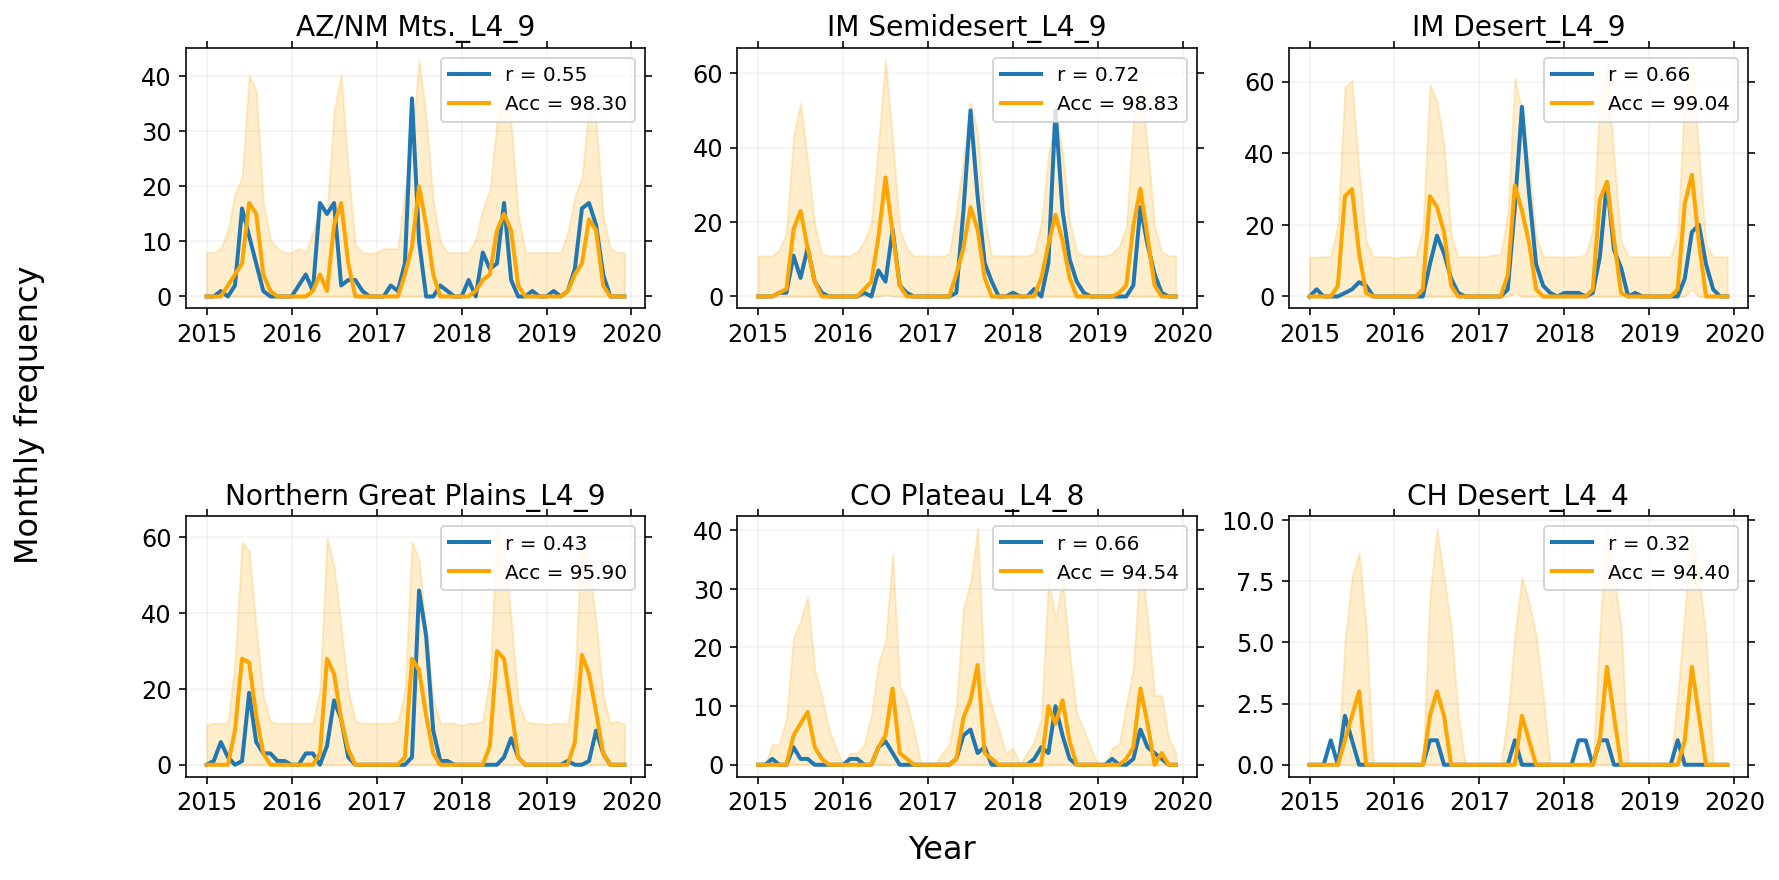

In [33]:
fig, ax= plt.subplots(2, 3, figsize=(14, 6.7))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in tqdm(range(2)):
    for j in range(3):
        regindx= ind_grid_2[i][j]
        mod_params= hp_df.loc[opt_freq_ind[regindx - 1]].to_dict()
        
        if mod_params['reg_flag'] == 'L4':
            if mod_params['func_flag'] == 'zipd':
                mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
                regmodels.append(zipd_model(mdn_L4_zipd.predict(x= tf.constant(X_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]]))))
            else:
                mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zinb_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
                regmodels.append(zinb_model(mdn_L4_zinb.predict(x= tf.constant(X_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]]))))
            
            reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
            fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                            for m in range(tot_months)])
            fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0
            
            freqsarr.append(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]])
            ax[i, j].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                for m in range(tot_months)]), lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
                   label= 'Acc = %.2f'%mod_params['Mod_Accuracy']);
            ax[i, j].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
        else:
            if mod_params['func_flag'] == 'zipd':
                mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zipd_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= True)
                regmodels.append(zipd_model(mdn_L3_zipd.predict(x= tf.constant(X_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]]))))
            else:
                mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zinb_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= True)
                regmodels.append(zinb_model(mdn_L3_zinb.predict(x= tf.constant(X_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]]))))

            reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
            freqsarr.append(y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]])
            ax[i, j].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                                label= 'Acc = %.2f'%mod_params['Mod_Accuracy']);
            ax[i, j].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                                     color= 'orange', alpha=0.2);

        ax[i, j].set_title('%s_'%reg_name[regindx] + '%s_'%mod_params['reg_flag'] + '%s'%mod_params['Iteration'], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].legend(loc='upper right', frameon= True);
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_fire_freq_2_emp_acc_rchisq_%s.pdf'%run_id, bbox_inches='tight');

In [29]:
freqsarr= np.concatenate(freqsarr)
empcdf_obs= tfd.Empirical(freqsarr)
cdf_emp_obs= empcdf_obs.cdf(freqsarr)

cdf_mod= tfd.BatchConcat(regmodels, axis= 0).cdf(freqsarr)

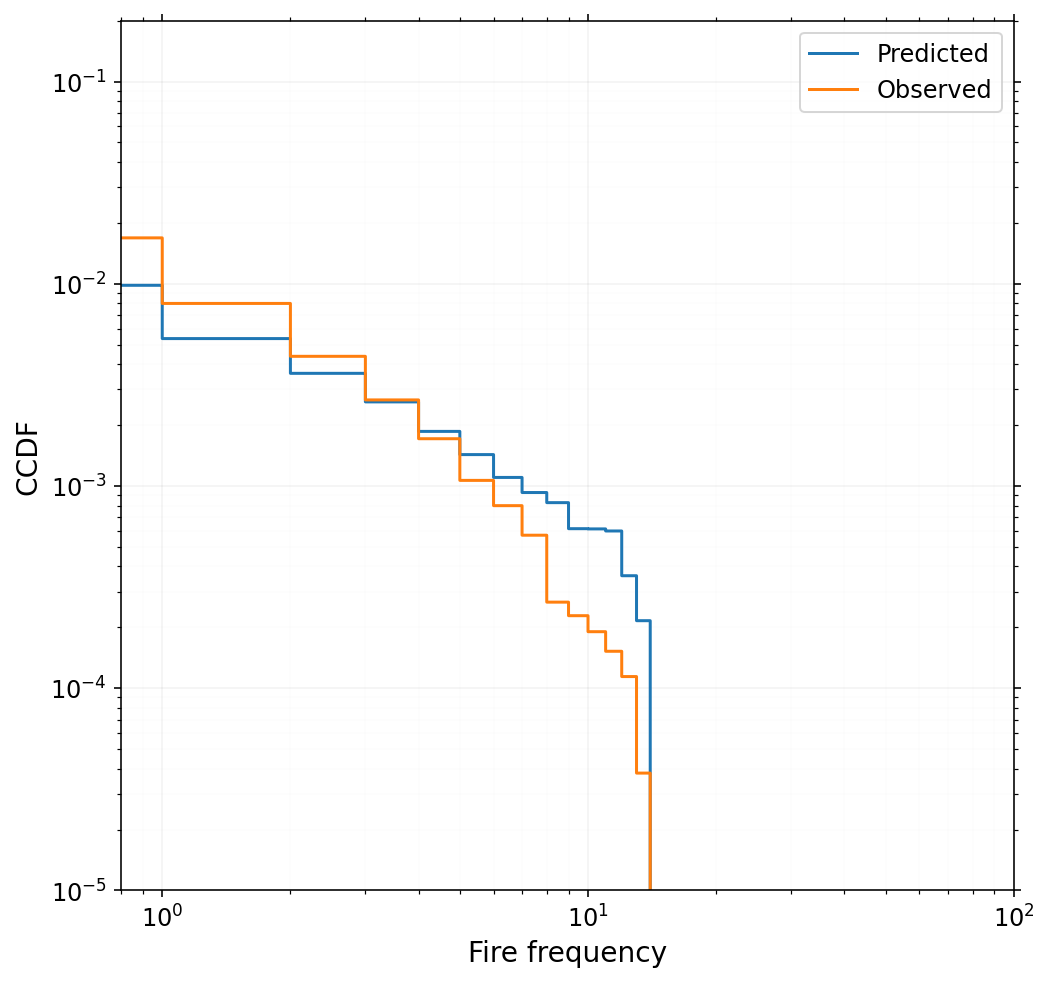

In [31]:
fig, ax= plt.subplots(figsize=(8, 8))

plt.step(np.append(np.sort(freqsarr), 30.), 1- np.append(np.sort(cdf_mod), 0.999999597), label= 'Predicted') #include linear interpolation instead
plt.step(np.sort(freqsarr), 1 - np.sort(cdf_emp_obs), label= 'Observed')

ax.set_xlabel(r'Fire frequency', fontsize= 14);
ax.set_ylabel(r'CCDF', fontsize= 14);

plt.ylim(10**-5, 0.2);
plt.xlim(0.8, 100);
plt.xscale('log')
plt.yscale('log')
plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.legend(loc='upper right', frameon=True, fontsize=12);
#plt.savefig('../plots/fire_freq_ccdf_%s.pdf'%run_id, bbox_inches='tight');

### 2.2 Frequency LOCO analysis

In [5]:
run_id= '22_01_28'
var_df= fire_freq_loco(fire_L3_freq_df, fire_L4_freq_df, n_iters= 50, n_epochs= 500, bs= 32, run_id= run_id)
var_df.to_hdf('../sav_files/loco_runs_%s/'%run_id + 'variables_loco_runs_%s.h5'%run_id, key= 'df', mode= 'w')

  0%|                                                    | 0/50 [00:00<?, ?it/s]

Initialized a MDN with 2 layers and 16 neurons
Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


2022-01-28 14:43:16.954997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-28 14:43:16.955169: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


MDN trained for 28 epochs


2022-01-28 14:44:25.703154: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 75 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 30 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 28 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_1_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
  2%|▊                                      | 1/50 [20:46<16:57:54, 1246.42s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 74 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 113 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 81 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 74 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 66 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 81 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 66 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 71 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 26 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_2_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
  4%|█▌                                     | 2/50 [48:54<20:04:52, 1506.09s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 30 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 21 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 32 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 30 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 39 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 39 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 66 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 39 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 39 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_3_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
  6%|██▏                                  | 3/50 [1:05:35<16:39:16, 1275.68s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 56 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 56 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 56 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 56 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 56 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 56 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 32 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 68 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 34 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_4_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
  8%|██▉                                  | 4/50 [1:29:08<16:59:38, 1329.96s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 83 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 73 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 84 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 84 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_5_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 10%|███▋                                 | 5/50 [1:59:42<18:53:47, 1511.73s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 126 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 106 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 162 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 129 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 182 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 96 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 113 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 157 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 115 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 83 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 149 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_6_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 12%|████▍                                | 6/50 [2:51:46<25:10:32, 2059.82s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 88 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 88 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_8/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 108 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_7_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 14%|█████▏                               | 7/50 [3:18:44<22:52:34, 1915.22s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 55 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 20 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 55 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 55 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 26 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 26 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_8_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 16%|█████▉                               | 8/50 [3:32:54<18:23:24, 1576.29s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 83 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 73 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 84 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 84 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_9_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 18%|██████▋                              | 9/50 [4:03:55<18:57:47, 1665.07s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_10_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 20%|███████▏                            | 10/50 [4:13:18<14:43:13, 1324.85s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 59 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 123 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 118 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 92 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 83 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 99 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 72 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 110 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 92 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 59 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 59 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_11_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 22%|███████▉                            | 11/50 [4:49:36<17:10:57, 1586.09s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 45 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 90 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 45 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 30 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 44 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 45 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 45 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 34 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 52 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 90 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 76 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_12_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 24%|████████▋                           | 12/50 [5:13:04<16:10:11, 1531.88s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 69 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 94 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 69 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_13_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 26%|█████████▎                          | 13/50 [5:39:56<15:59:35, 1556.08s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 63 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 63 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 97 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 91 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 103 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 90 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 58 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_14_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 28%|██████████                          | 14/50 [6:10:19<16:22:09, 1636.93s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 191 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 144 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 138 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 151 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 169 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 151 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 191 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 140 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 136 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 178 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 191 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_15_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 30%|██████████▊                         | 15/50 [7:15:02<22:29:44, 2313.84s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 85 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 90 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 82 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 80 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 93 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 63 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_16_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 32%|███████████▌                        | 16/50 [7:48:42<21:01:03, 2225.39s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 28 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 29 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 49 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 37 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 37 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 37 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 41 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 37 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 29 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 37 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_17_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 34%|████████████▏                       | 17/50 [8:05:21<17:01:12, 1856.74s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 87 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 102 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 105 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 76 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 102 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 48 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_5/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 105 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 48 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_7/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 102 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 83 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 143 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_18_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 36%|████████████▉                       | 18/50 [8:42:54<17:33:45, 1975.78s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 23 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 19 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 19 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 19 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 47 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 24 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 47 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_19_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 38%|█████████████▋                      | 19/50 [8:54:58<13:46:34, 1599.83s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 40 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 24 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 20 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_20_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 40%|██████████████▍                     | 20/50 [9:07:18<11:10:48, 1341.60s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 74 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 113 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 81 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 74 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 66 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 81 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 66 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 71 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 26 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_21_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 42%|███████████████                     | 21/50 [9:35:26<11:38:43, 1445.63s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 63 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 94 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 63 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 122 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 109 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 68 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 63 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 68 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 63 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 36 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 77 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_22_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 44%|███████████████▍                   | 22/50 [10:06:47<12:15:31, 1576.11s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 81 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_23_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 46%|████████████████▌                   | 23/50 [10:18:26<9:50:54, 1313.12s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 93 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 127 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 67 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 67 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 103 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 67 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 81 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 127 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_24_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 48%|████████████████▊                  | 24/50 [10:55:52<11:30:11, 1592.77s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 38 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 19 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_8/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 55 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 59 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_25_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 50%|██████████████████                  | 25/50 [11:11:01<9:38:10, 1387.62s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 19 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_26_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 52%|██████████████████▋                 | 26/50 [11:22:05<7:48:14, 1170.59s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 93 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 127 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 67 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 67 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 103 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 67 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 81 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 127 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_27_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 54%|███████████████████▍                | 27/50 [11:56:05<9:08:44, 1431.49s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 37 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_3/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 48 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 95 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 41 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_7/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 37 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 37 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_28_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 56%|████████████████████▏               | 28/50 [12:15:59<8:18:42, 1360.12s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 78 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_3/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_5/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_7/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 104 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 119 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_29_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])
 58%|████████████████████▉               | 29/50 [12:40:39<8:08:41, 1396.27s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 78 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_3/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_5/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 43 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_7/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 70 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 104 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 119 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_30_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])
 60%|█████████████████████▌              | 30/50 [13:05:21<7:53:57, 1421.88s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 91 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 215 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 232 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 137 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 137 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 137 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 137 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 137 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 137 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 91 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_31_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])
 62%|█████████████████████▋             | 31/50 [13:55:38<10:01:50, 1900.55s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 152 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 151 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 147 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 147 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 122 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 159 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 126 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 159 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 147 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 175 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 126 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_32_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 64%|██████████████████████▍            | 32/50 [14:48:55<11:26:49, 2289.42s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 53 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 59 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 78 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 59 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 55 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 34 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 51 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 54 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 57 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 55 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 53 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_33_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])
 66%|███████████████████████▊            | 33/50 [15:10:33<9:24:21, 1991.84s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 59 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_34_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 139 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_34_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 146 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_34_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 45 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_34_var_3/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 32 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_34_var_4/assets
Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 56 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_34_var_5/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 45 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_34_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN traine

 68%|████████████████████████▍           | 34/50 [15:36:03<8:14:13, 1853.33s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 16 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_35_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 70%|█████████████████████████▏          | 35/50 [15:44:36<6:02:50, 1451.36s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 85 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 44 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 17 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 34 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_36_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 72%|█████████████████████████▉          | 36/50 [16:01:38<5:08:33, 1322.43s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 88 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 88 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_8/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 108 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_37_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 74%|██████████████████████████▋         | 37/50 [16:26:07<4:56:03, 1366.42s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 28 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 75 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 30 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 28 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 46 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_38_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 76%|███████████████████████████▎        | 38/50 [16:44:53<4:18:54, 1294.51s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 52 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 87 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 29 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 30 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 52 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 52 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_39_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 78%|████████████████████████████        | 39/50 [17:05:00<3:52:28, 1268.01s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 52 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 87 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 29 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 50 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 30 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 52 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 52 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_40_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 80%|████████████████████████████▊       | 40/50 [17:25:06<3:28:16, 1249.60s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 76 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 47 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 53 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 82 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 82 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 79 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 105 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_41_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 82%|█████████████████████████████▌      | 41/50 [17:54:13<3:29:48, 1398.75s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 88 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 60 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 88 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 42 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_8/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 108 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_42_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 84%|██████████████████████████████▏     | 42/50 [18:18:43<3:09:21, 1420.19s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 62 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 142 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 92 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 92 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 142 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 62 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_8/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 128 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 119 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_43_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 86%|██████████████████████████████▉     | 43/50 [18:56:13<3:14:43, 1669.01s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 44 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 51 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 57 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 71 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 57 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 69 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 57 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 87 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 69 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 57 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_44_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 88%|███████████████████████████████▋    | 44/50 [19:20:59<2:41:24, 1614.08s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 41 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 45 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 44 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 21 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 38 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 35 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_45_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
 90%|████████████████████████████████▍   | 45/50 [19:36:03<1:56:45, 1401.07s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 62 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 142 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 92 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 92 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 89 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 142 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 62 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_8/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 128 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 119 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_46_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 92%|█████████████████████████████████   | 46/50 [20:13:31<1:50:21, 1655.33s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 82 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 126 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 82 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_2/assets
Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 108 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 114 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 131 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 82 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 82 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 106 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 76 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 82 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_47_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 94%|█████████████████████████████████▊  | 47/50 [20:49:51<1:30:37, 1812.53s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 51 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 47 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 18 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 47 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 56 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:882: RuntimeWarning: invalid value encountered in double_scalars
  list_of_lists.append([it + 1, var, regindx + 1, pearson_r[0], chisq_1/dof, emp_accuracy, mod_accuracy.numpy(), mod_loss.numpy()])


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 22 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 47 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 47 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 51 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_48_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 96%|████████████████████████████████████▍ | 48/50 [21:05:52<51:54, 1557.15s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 81 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 113 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 57 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 57 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_49_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 98%|█████████████████████████████████████▏| 49/50 [21:31:31<25:51, 1551.75s/it]

Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_0/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 86 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_1/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 90 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_2/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 80 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_3/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 105 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_4/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 95 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_5/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 61 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_6/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 105 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_7/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_8/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2


Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_9/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 16 neurons
MDN trained for 31 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_runs_22_01_28/mdn_L4_zipd_iter_run_50_var_10/assets


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: invalid value encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/ml_utils.py:878: RuntimeWarning: divide by zero encountered in true_divide
  errarr_1= 4*(mean_freqs - obs_freqs)**2/(high_freqs - low_freqs)**2
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████████████████████████████████| 50/50 [21:57:29<00:00, 1581.00s/it]


In [6]:
run_id= '22_01_28'
n_regions= 18
var_df= pd.read_hdf('../sav_files/loco_runs_%s'%run_id + '/variables_loco_runs_%s.h5'%run_id)
var_df['tot_metric']= var_df['Emp_Accuracy']/var_df['Red_ChiSq_1'] #hp_df= hp_df.drop([2, 14, 30]) --> '22_01_24' 

In [8]:
varlist= np.array(['All', 'VPD', 'Tmax', 'Prec', 'Forest', 'FM1000', 'Ant_VPD', 'Antprec', 'Avgprec', 'Urban', 'FFWI'])

In [17]:
sierra_loss= np.asarray([np.mean(var_df.groupby('reg_indx').get_group(3).groupby('Variable').get_group(v)['Loss']) for v in range(len(varlist))])

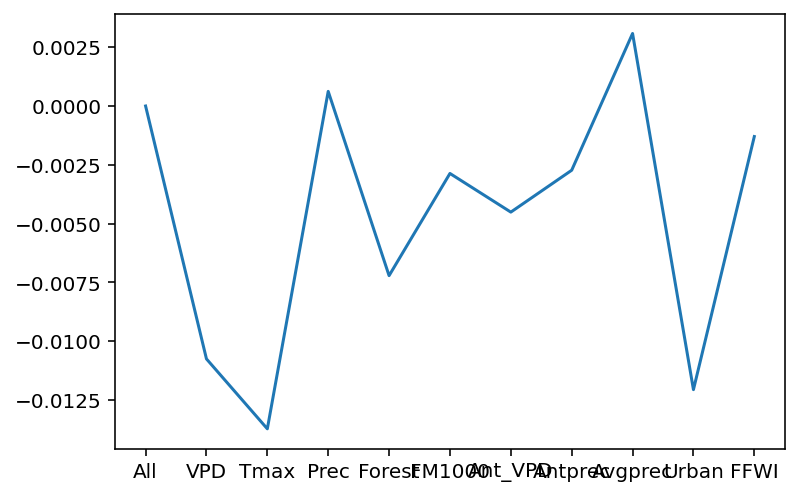

In [18]:
plt.plot(varlist, sierra_loss - sierra_loss[0])

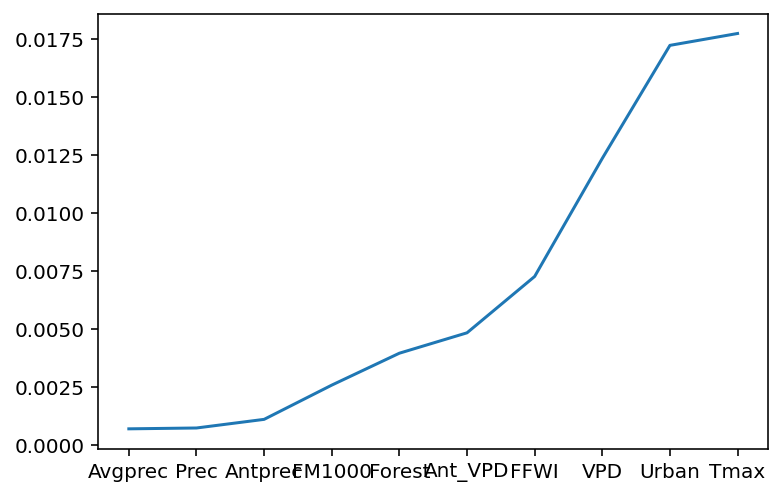

In [14]:
reg_avg_loss= np.asarray([np.mean([np.mean(var_df.groupby('reg_indx').get_group(r+1).groupby('Variable').get_group(v)['Loss']) for r in range(n_regions)]) for v in range(len(varlist))])
argind= np.argsort(abs(reg_avg_loss - reg_avg_loss[0]))
plt.plot(varlist[argind][1:], np.sort(abs(reg_avg_loss - reg_avg_loss[0]))[1:])

## Metrics expt

In [66]:
l4_freqs= y_L4_freqs_test[cumreglen[4]:cumreglen[5]]
obs_input= X_L4_freqs_test[cumreglen[4]:cumreglen[5]]

mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_3', \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
param_vec= mdn_L4_zipd.predict(x= tf.constant(obs_input))
y_L4_pred= tf.floor(tf.reduce_mean(zipd_model(param_vec).sample(10000), axis= 0))

In [77]:
l4_zinb_freqs= y_L4_freqs_test[cumreglen[5]:cumreglen[6]]
obs_zinb_input= X_L4_freqs_test[cumreglen[5]:cumreglen[6]]

mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zinb_iter_3', \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
param_zinb_vec= mdn_L4_zinb.predict(x= tf.constant(obs_zinb_input))

In [ ]:
np.histogram(y_L4_freqs_test[cumreglen[4]:cumreglen[5]])

(array([2626,    9,    4,    0,    0,    0,    0,    0,    0,    1]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ],
       dtype=float32))

In [68]:
l4_freqs= y_L4_freqs_test[cumreglen[4]:cumreglen[5]]
obs_input= X_L4_freqs_test[cumreglen[4]:cumreglen[5]]

In [69]:
mdn_1= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_8', \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
pvec_1= mdn_1.predict(x= tf.constant(obs_input))
y_pred_1= tf.floor(tf.reduce_mean(zipd_model(pvec_1).sample(10000), axis= 0))

In [70]:
zipd_loss(l4_freqs, pvec_1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25375062>

In [72]:
mdn_2= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zinb_iter_3', \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
pvec_2= mdn_2.predict(x= tf.constant(obs_input))
y_pred_2= tf.floor(tf.reduce_mean(zinb_model(pvec_2).sample(10000), axis= 0))

In [73]:
zinb_loss(l4_freqs, pvec_2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.73745924>

In [74]:
empcdf= tfd.Empirical(y_L4_freqs_test[cumreglen[4]:cumreglen[5]])
cdf_obs= empcdf.cdf(y_L4_freqs_test[cumreglen[4]:cumreglen[5]])

In [75]:
empcdf_1= tfd.Empirical(y_pred_1)
cdf_1= empcdf_1.cdf(y_pred_1)

empcdf_2= tfd.Empirical(y_pred_2)
cdf_2= empcdf_2.cdf(y_pred_2)

In [76]:
100 - tf.abs(100*(-tf.reduce_mean(tf.math.log(cdf_1/cdf_obs), axis= 0)))

<tf.Tensor: shape=(), dtype=float32, numpy=87.75865>

In [77]:
100 - 100*(tf.reduce_mean(tf.abs(cdf_1 - cdf_obs), axis= 0))

<tf.Tensor: shape=(), dtype=float32, numpy=88.20306>

In [78]:
100 - 100*(tf.reduce_mean(tf.abs(cdf_2 - cdf_obs), axis= 0))

<tf.Tensor: shape=(), dtype=float32, numpy=66.12222>

In [79]:
100 - tf.abs(100 *(-tf.reduce_mean(tf.math.log(cdf_2/cdf_obs), axis= 0)))

<tf.Tensor: shape=(), dtype=float32, numpy=53.50995>

In [84]:
pmf_pred_1= zipd_model(pvec_1).prob(l4_freqs)
pmf_pred_2= zinb_model(pvec_2).prob(l4_freqs)

In [85]:
pmf_obs= empcdf.prob(l4_freqs)

In [86]:
stat

0.0032069471

In [87]:
stats.entropy(pmf_obs, qk= pmf_pred_2)

0.13214958

## Sanity checks

In [ ]:
hp_df.groupby('reg_indx').get_group(5).sort_values(by= ['tot_metric'], ascending= False)

,Iteration,reg_indx,reg_flag,func_flag,Pearson_r,Red_ChiSq,Accuracy,tot_metric
523,8,5,L4,zipd,0.598704,37.548096,94.728836,56.714561
595,9,5,L4,zipd,0.598704,37.548096,94.728836,56.714561
163,3,5,L4,zipd,0.589831,81.152927,91.166580,53.772920
451,7,5,L4,zipd,0.590050,364.577959,84.446266,49.827536
450,7,5,L4,zinb,0.528833,36.146325,92.574211,48.956312
307,5,5,L4,zipd,0.521893,72.369780,93.313736,48.699760
90,2,5,L4,zinb,0.490550,28.037983,93.346146,45.790930
162,3,5,L4,zinb,0.479929,22.005523,95.293655,45.734212
161,3,5,L3,zipd,0.597955,165.899259,72.830902,43.549578
378,6,5,L4,zinb,0.473973,76.615972,91.124794,43.190725


100%|██████████| 18/18 [00:02<00:00,  7.74it/s]


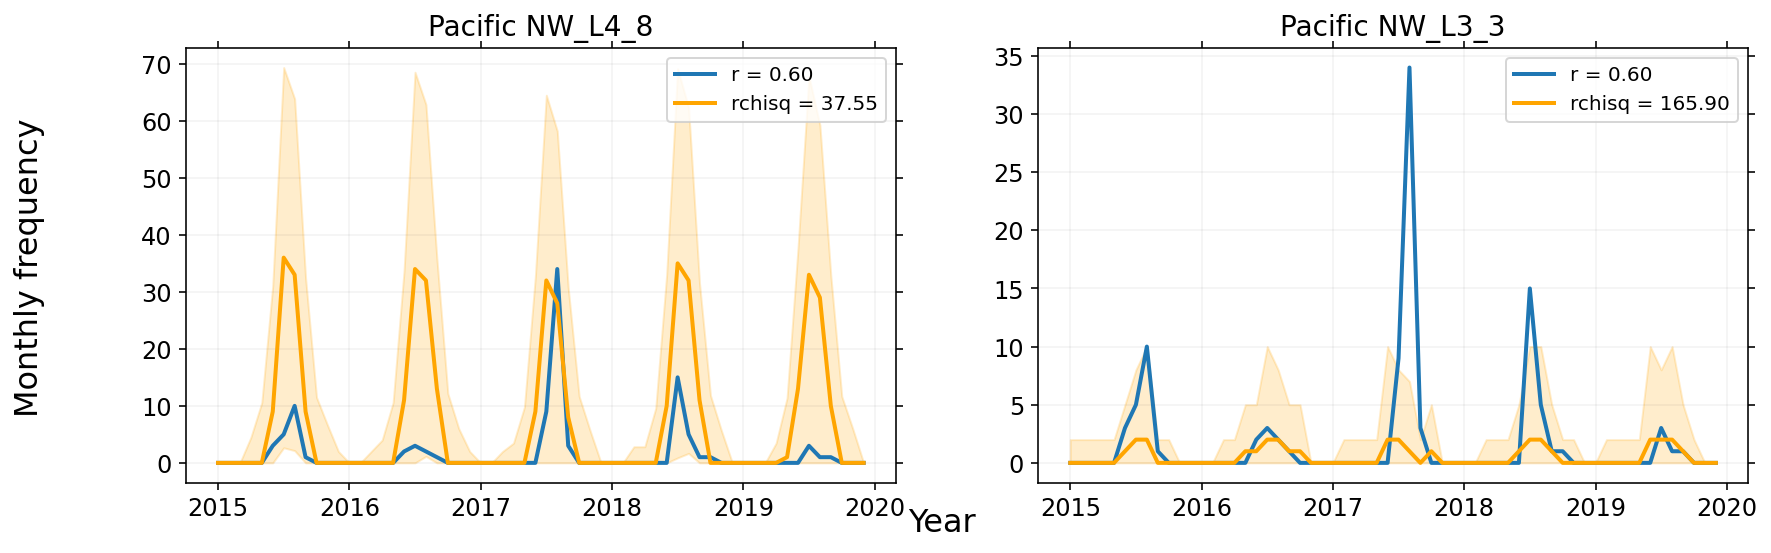

In [13]:
fig, ax= plt.subplots(1, 2, figsize=(14, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

regindx= 5
mod_1_params= {'Iteration': 8, 'reg_flag': 'L4', 'func_flag': 'zipd', 'best_ind': 0}
mod_2_params= {'Iteration': 3, 'reg_flag': 'L3', 'func_flag': 'zinb', 'best_ind': 8}
        
if mod_1_params['reg_flag'] == 'L4':
    if mod_1_params['func_flag'] == 'zipd':
        mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_%d'%(mod_1_params['Iteration']), \
                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    else:
        mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zinb_iter_%d'%(mod_1_params['Iteration']), \
                                                                            custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    
    reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
    fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                    for m in range(tot_months)])
    fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0

    ax[0].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                        for m in range(tot_months)]), lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Pearson_r']);
    ax[0].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
           label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Red_ChiSq']);
    ax[0].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
else:
    if mod_1_params['func_flag'] == 'zipd':
        mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zipd_iter_%d'%(mod_1_params['Iteration']), \
                                                custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= False)
    else:
        mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zinb_iter_%d'%(mod_1_params['Iteration']), \
                                                custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= False)
        
    reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
    ax[0].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Pearson_r']);
    ax[0].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                        label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Red_ChiSq']);
    ax[0].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                             color= 'orange', alpha=0.2);
       
ax[0].set_title('%s_'%reg_name[regindx] + '%s_'%mod_1_params['reg_flag'] + '%s'%mod_1_params['Iteration'], fontsize= 14);
ax[0].set_xticks((year_arr - 2015)*12);
ax[0].set_xticklabels(year_arr)
fig.subplots_adjust(hspace= 0.8)
#fig.minorticks_on()
ax[0].legend(loc='upper right', frameon= True);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

if mod_2_params['reg_flag'] == 'L4':
    if mod_2_params['func_flag'] == 'zipd':
        mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_%d'%(mod_2_params['Iteration']), \
                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    else:
        mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zinb_iter_%d'%(mod_2_params['Iteration']), \
                                                                            custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    
    reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
    fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                    for m in range(tot_months)])
    fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0

    ax[1].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                        for m in range(tot_months)]), lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Pearson_r']);
    ax[1].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
           label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Red_ChiSq']);
    ax[1].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
else:
    if mod_2_params['func_flag'] == 'zipd':
        mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zipd_iter_%d'%(mod_2_params['Iteration']), \
                                                custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= False)
    else:
        mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zinb_iter_%d'%(mod_2_params['Iteration']), \
                                                custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= False)
        
    reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
    ax[1].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Pearson_r']);
    ax[1].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                        label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Red_ChiSq']);
    ax[1].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                             color= 'orange', alpha=0.2);
    
ax[1].set_title('%s_'%reg_name[regindx] + '%s_'%mod_2_params['reg_flag'] + '%s'%mod_2_params['Iteration'], fontsize= 14);
ax[1].set_xticks((year_arr - 2015)*12);
ax[1].set_xticklabels(year_arr)
fig.subplots_adjust(hspace= 0.8)
ax[1].legend(loc='upper right', frameon= True);

ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_L4_fire_freq_1_alt.pdf', bbox_inches='tight');

In [10]:
%time reg_ml_size_df, h_size= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, \
                    y_val_dat= y_sizes_val, X_test_dat= X_sizes_test, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, func_flag= 'gpd', freq_flag= 'data', freqs_data= fire_freq_L3_data, iter_run= 1)
reg_ml_size_groups= reg_ml_size_df.groupby('reg_indx')

2021-12-03 18:26:40.330438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 18:26:40.849707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 10 epochs


2021-12-03 18:26:43.639620: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../sav_files/model_gpd_8_2_he_normal_0.001_iter_1/assets


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:20<00:00,  1.13s/it]

CPU times: user 20 s, sys: 5.84 s, total: 25.8 s
Wall time: 24.4 s


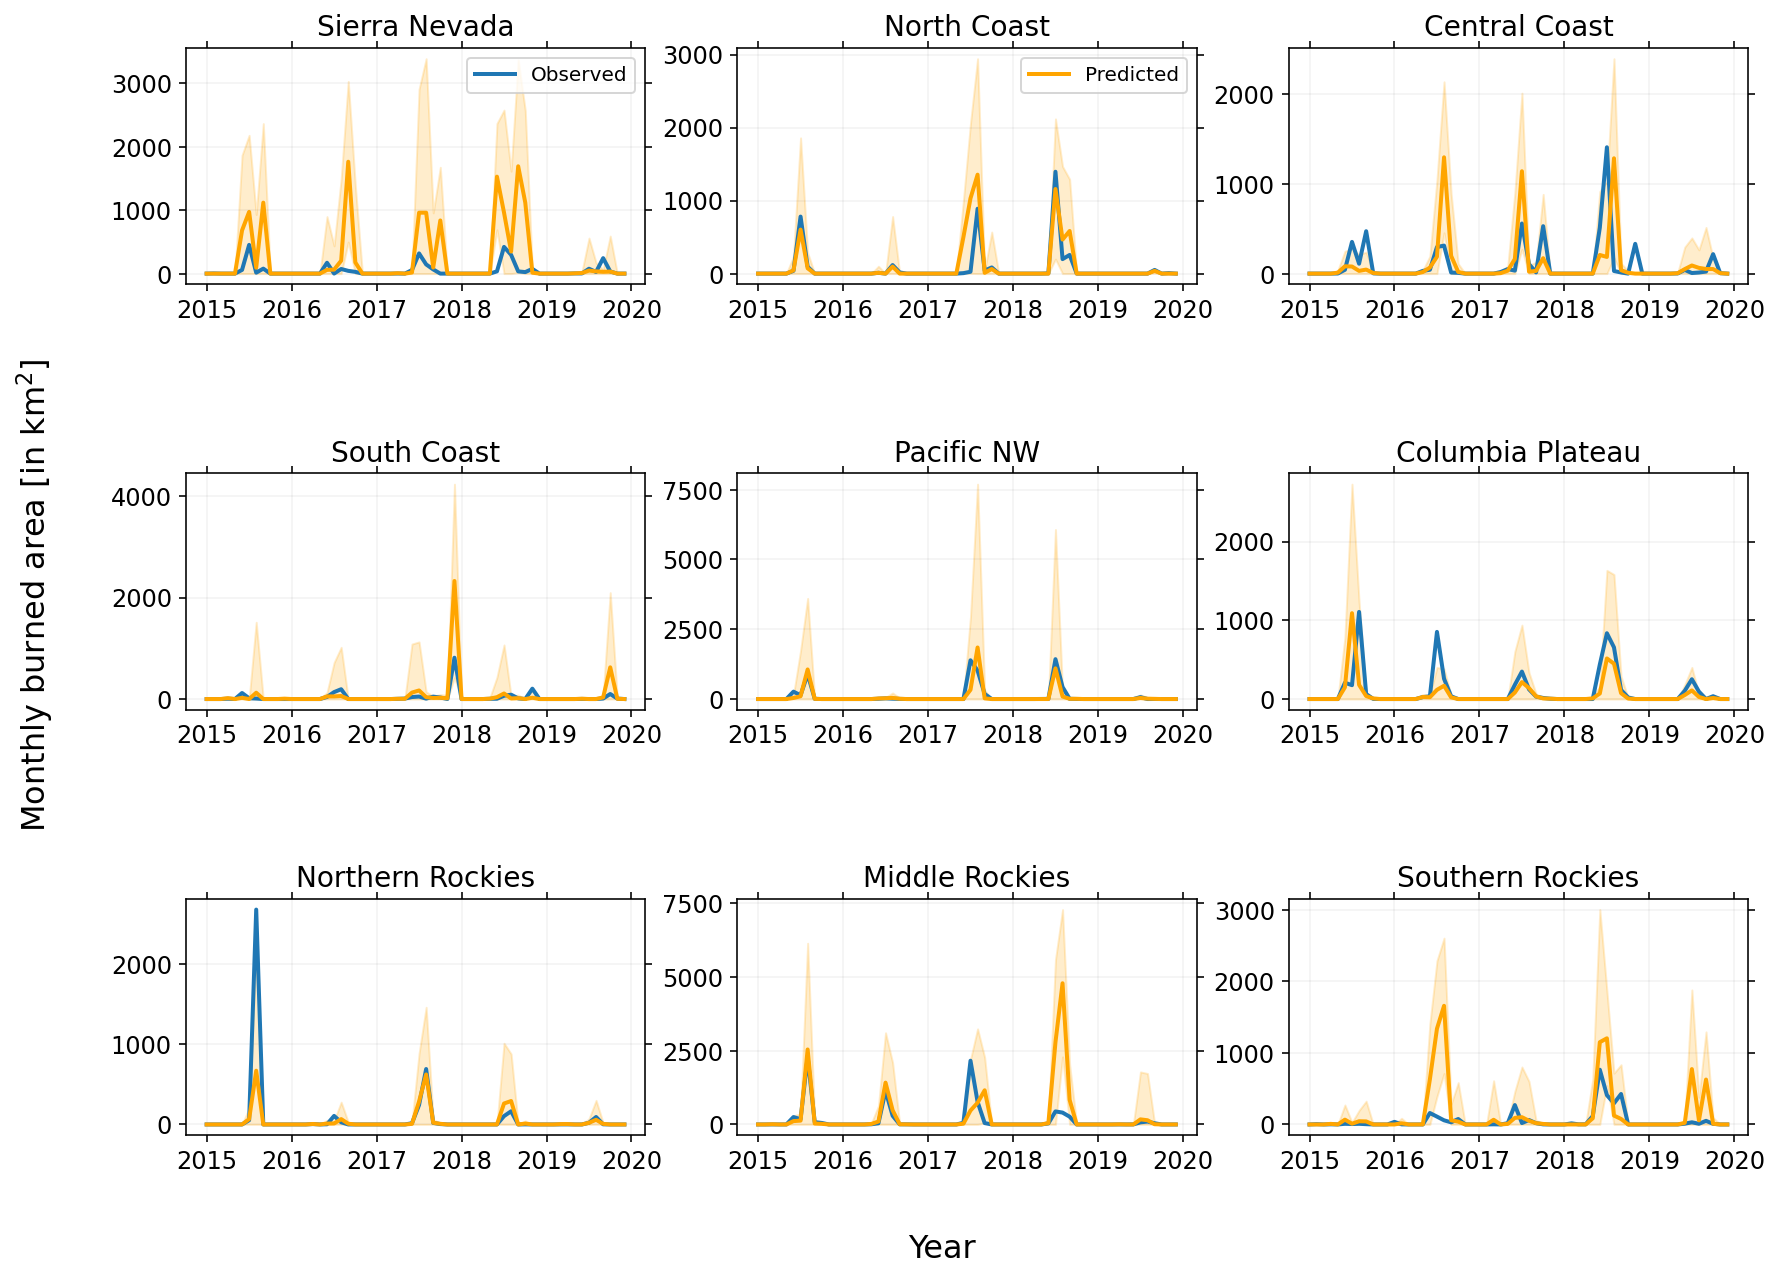

In [53]:
ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[10, 11, 12], [13, 14, 15], [16, 17, 18]]

fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(3):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[372:], lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[372:], lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2);
        ax[i, j].fill_between(month_arr, reg_ml_size_groups.get_group(regindx)['high_1sig_size'], reg_ml_size_groups.get_group(regindx)['low_1sig_size'], \
                                                                                                                             color= 'orange', alpha=0.2);
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
        

#plt.savefig('../plots/ml_eff_const_fire_size_1_24km.pdf', bbox_inches='tight');